## Images metadata extraction using Google AutoML Vision API

### Introduction

When you have a storage of hundreds or thousands of image files, one hard task is to locate images with a specific characteristic - like images from a specific place or images containing some specific information - like dogs or cars.

In this tutorial we gonna go through an step by step of how to perform the following tasks using Google AutoML:
- analyze image files and extract metadata
- identify locations, objects and some more information on those images
- as a prototype/proof of concept experience, those information will be stored on a dataframe
- a mimic'ed image search will be performed -- searching for images based on metadata information

**It is important reinforce:** all those results are possible to be generated with agility and high confidence without the need of manually training, optimizing and testing machine learning models or writing machine learning code - which increases drastically the time to market of generated solutions.

A reference about AutoML Vision features and functionalities can be found at: https://cloud.google.com/vision/automl/docs

### How does AutoML Vision API work?

AutoML is a managed service available at Google Cloud where training data and machine learning models are created, curated and managed by Google and customers only need to run predictions/inferences against the available API.

AutoML Vision API is able to get characteristics from images, including detecting objects, labeling scene information, reading texts from the images, etc, with simple and fast API calls. Below you can see a quick example using a sample image found on Google Images:

<img src="images/sample.png" width="600" /> 

### Preparation Steps

Before starting, it is important to:

**a) First, install the required Python modules:**
- googleapis-common-protos
- google-cloud-automl
- google-cloud-translate
- pandas

To install those packages simply run:

`$ sudo pip3 install googleapis-common-protos google-cloud-automl google-cloud-translate pandas`

**b) Also, validate that you have a valid Application Credential to use on this exercise**

If you don't have or if you don't know, please check: https://cloud.google.com/docs/authentication/getting-started

Below just follow and execute the code cells to perform the activity

**c) Then, you need the dataset used on this exercise**

It is available at https://storage.googleapis.com/openimages/web/download.html -- you can click on "Download from Figure Eight" and download the "Open Images Challenge 2019 Test Set" - as below:

`$ wget https://datasets.appen.com/appen_datasets/open-images/test_challenge.zip`

`$ unzip test_challenge.zip`

It will create a directory called `./challenge2018/` that you will be using in this notebook.

In [1]:
# import initial required modules
import os
import io
import ast
import datetime
from google.cloud import vision
from google.cloud import translate_v2 as translate

In [2]:
## configure environment variables for authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '<add your credential here>'

In [3]:
## Vision API client definition
client_vision = vision.ImageAnnotatorClient()

## Translate API client definition
client_translate = translate.Client()
target_language = 'pt'

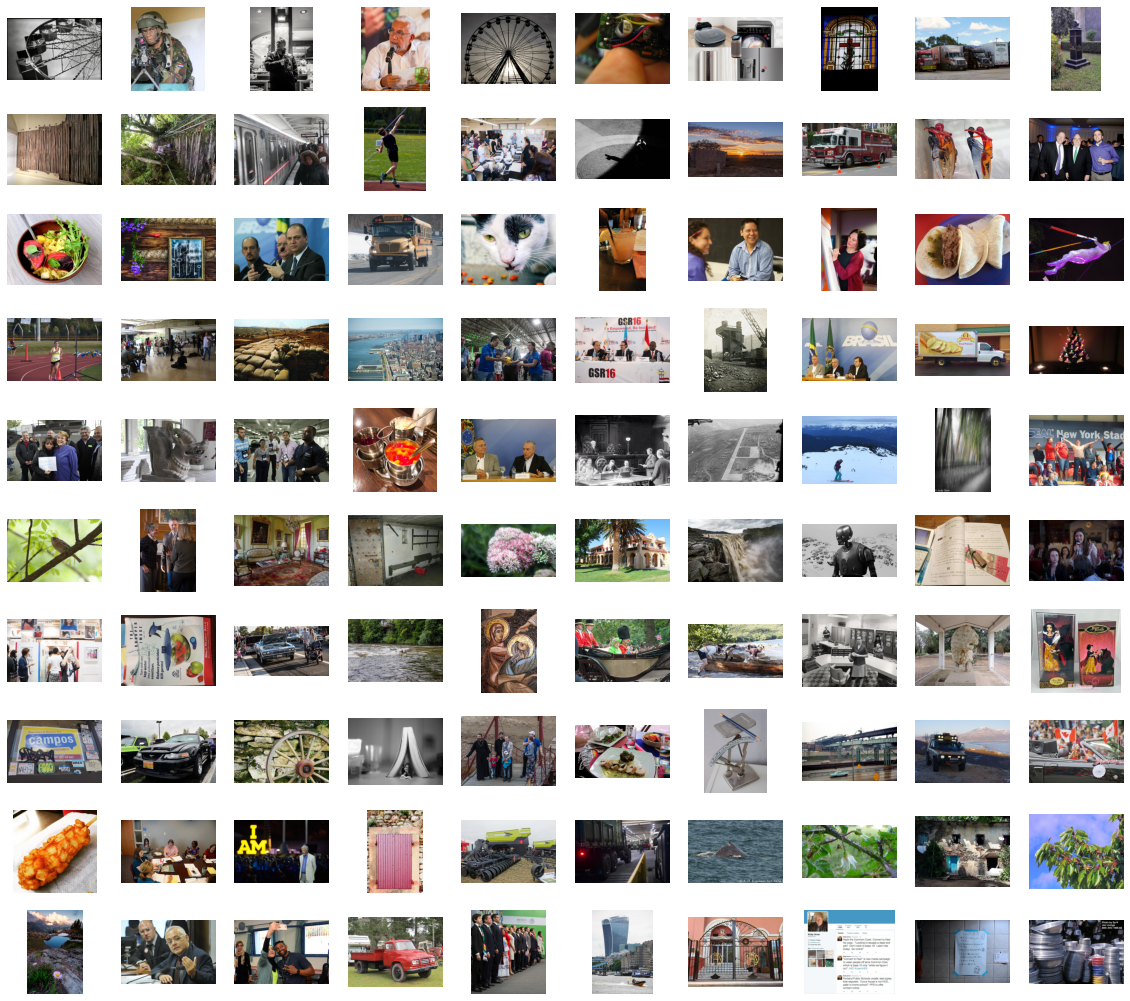

In [4]:
## import a sample of 100 images from the Open Images dataset

%matplotlib inline

import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

random_files = []
path = './challenge2018/'
files = os.listdir(path)

for _ in range(100):
    random_file = path + random.choice(files)
    if (random_file not in random_files) and ('jpg' in random_file):
        random_files.append(random_file)

## plot the 100 sample images 

plt.figure(figsize=(20,20))
columns = 10
for i, image in enumerate(random_files):
    plt.subplot(len(random_files) / columns + 1, columns, i + 1)
    plt.imshow(imread(random_files[i]))
    plt.axis('off')

In [5]:
## function to inspect a given image and extract labels, objects and landmarks information metadata

def analyzeImage(img):
    labels_suggestion = []

    ## reading the image file data
    with io.open(img, 'rb') as image_file:
            content = image_file.read()
    image = vision.types.Image(content=content)

    ## checking information for labels, objects and landmarks
    labels = client_vision.label_detection(image=image)
    objects = client_vision.object_localization(image=image).localized_object_annotations
    landmarks = client_vision.landmark_detection(image=image)


    ## detect labels on a given image
    for label in labels.label_annotations:
        score = label.score*100
        if (score >= 80) and (label.description not in labels_suggestion):
            labels_suggestion.append(label.description)

    ## detect objects on a given image
    for obj in objects:
        score = obj.score*100
        if (score >= 70) and (obj.name not in labels_suggestion):
            labels_suggestion.append(obj.name)

    ## detect landmarks (if any) on a given image
    for landmark in landmarks.landmark_annotations:
        score = landmark.score*100
        if (score >= 30) and (landmark.description not in labels_suggestion):
            labels_suggestion.append(landmark.description)

    # translate all the image metadata (labels, objects and landmarks)
    label_list = []

    for label in labels_suggestion:
        translation = client_translate.translate(label, target_language=target_language)
        label_list.append(translation['translatedText'])

    return(', '.join(label_list))

In [6]:
## generating a Pandas DataFrame combining the images location and images metadata
# it is going to mimic a 'database'-like infrastructure, where searches will be performed

import pandas as pd

data = {'image':  [],
        'metadata': []}
images_metadata = pd.DataFrame(data, columns = ['image','metadata'])

for image in random_files:
    metadata = analyzeImage(image)
    images_metadata.loc[-1] = [image, metadata]
    images_metadata.index = images_metadata.index + 1
    images_metadata = images_metadata.sort_index()

CPU times: user 2.16 s, sys: 184 ms, total: 2.34 s
Wall time: 1min 37s


In [7]:
## a quick look on how the DataFrame looks like

images_metadata

image  \
0   ../../dataset/challenge2018/6062423550baeb2a.jpg   
1   ../../dataset/challenge2018/d2b199d96703c072.jpg   
2   ../../dataset/challenge2018/41f9ab9b11f1f60b.jpg   
3   ../../dataset/challenge2018/65a37c7b1de607df.jpg   
4   ../../dataset/challenge2018/79fa551430993ac2.jpg   
..                                               ...   
95  ../../dataset/challenge2018/fd9b326aef1fedba.jpg   
96  ../../dataset/challenge2018/a2a5c7a08e13d1d6.jpg   
97  ../../dataset/challenge2018/26985d66bdb38b5f.jpg   
98  ../../dataset/challenge2018/89a3d40b9b2b921f.jpg   
99  ../../dataset/challenge2018/8116b79f5ad30622.jpg   

                                             metadata  
0                                     produtos, Metal  
1                                               Texto  
2                                       Texto, Pessoa  
3                           Ferro, Metal, Arquitetura  
4   área metropolitana, Arranha-céu, Arquitetura, ...  
..                                                ...  
95  roda gigante, Roda, Atração turística, Ponto d...  
96           Óculos, Pessoa, Microfone, Copo de vinho  
97  Branco, Preto, Fotografia, Monocromático, Pret...  
98  Soldado, Exército, Camuflagem militar, Militar...  
99  roda gigante, Atração turística, Preto e branc...  

[100 rows x 2 columns]

In [8]:
## performing a search for images that contain the label 'Carro' (car in Portuguese)
# it will create a list with image locations
pattern = 'Carro'
results = images_metadata[images_metadata['metadata'].str.contains(pattern, case = False, regex = False)]
results = results['image'].tolist()
results

['../../dataset/challenge2018/78b9ad207f58ca78.jpg',
 '../../dataset/challenge2018/7c1dd6dcd68d8a62.jpg',
 '../../dataset/challenge2018/ea4d4751558068e1.jpg',
 '../../dataset/challenge2018/4788ae329093ec09.jpg',
 '../../dataset/challenge2018/70b6e198fcaf57c1.jpg',
 '../../dataset/challenge2018/ee29dec8989f7791.jpg',
 '../../dataset/challenge2018/5a3ac5f144aa3d34.jpg',
 '../../dataset/challenge2018/2ee81ecbfe2f6ca9.jpg',
 '../../dataset/challenge2018/7dad15ab08d08055.jpg',
 '../../dataset/challenge2018/9d1b7493b0064a8f.jpg',
 '../../dataset/challenge2018/78443add61522ef5.jpg',
 '../../dataset/challenge2018/fed02dccdc0061dc.jpg']

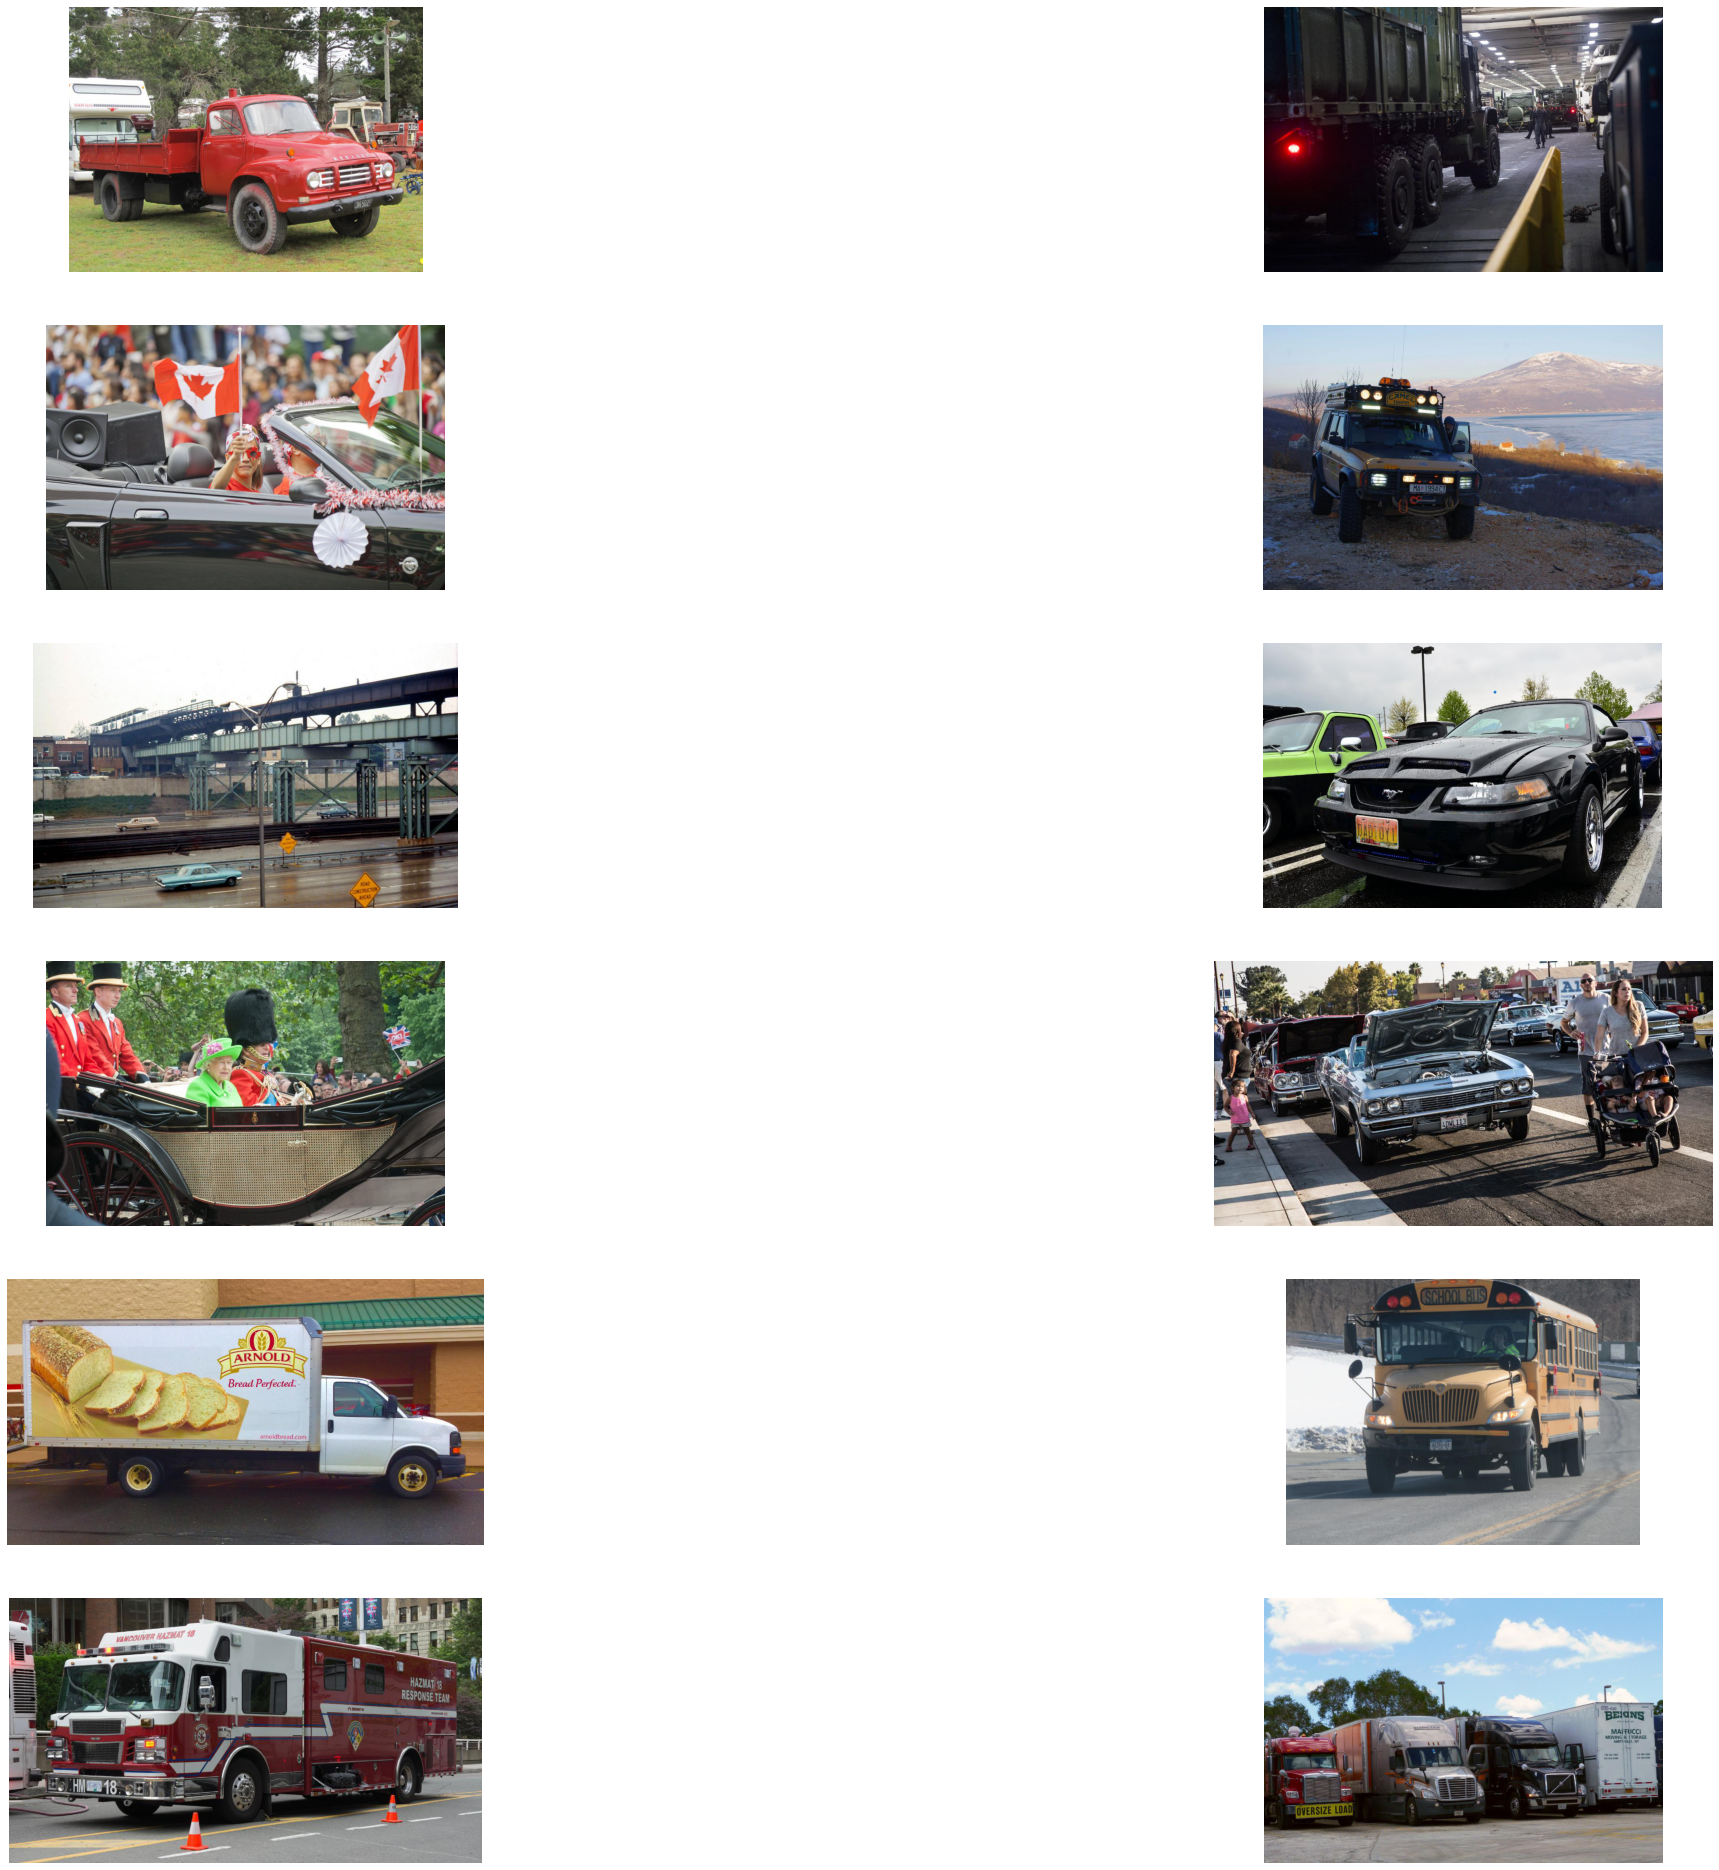

In [9]:
## plotting the images with 'Carro' metadata found on the 'database'

plt.figure(figsize=(40,40))
columns = 2
for i, image in enumerate(results):
    plt.subplot(len(results) / columns + 1, columns, i + 1)
    plt.imshow(imread(results[i]))
    plt.axis('off')